# Transfer Learning
Transfer Learning is a technique where we use a pre trained model on another similar problem on which the model is not trained. 
We will use VGG16 pre trained model and exclude last layer.
First we will load our dataset.

#Loading Dataset


In [1]:
!pip install --upgrade --ignore-installed kaggle

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 153kB 11.1MB/s 
     |████████████████████████████████| 235kB 17.8MB/s 
     |████████████████████████████████| 61kB 11.4MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 143kB 47.6MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 184kB 44.2MB/s 
     |████████████████████████████████| 81kB 14.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=9bd4cd0ed73af42549ea8780187a5b14839c402cad94c122bb185483e9aaa50d
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=ff542176ac60232ad5c4b7d2e50ca6c286544f1c4373cc82789aeeb7ecadecb3
  Stored in directory: /root/.cache/pip/wheels/67/b8/ba/041548f30a6fc058c9

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bushrafatima00000","key":"b58267cc73b3a7a3b5b1169515f56683"}'}

In [3]:

!mkdir ~/.kaggle #created at root folder in colab

In [4]:
!cp kaggle.json ~/.kaggle

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
utkarshxy/who-worldhealth-statistics-2020-complete             World Health 2020 🌏 | For Geospatial Analysis         1MB  2021-01-06 16:22:50           1047        143  1.0              
gpreda/pfizer-vaccine-tweets                                   Pfizer Vaccine Tweets                               416KB  2021-01-07 12:08:56            771         82  1.0              
google/android-smartphones-high-accuracy-datasets              Android smartphones high accuracy GNSS datasets       1GB  2020-12-23 01:51:11            148         31  0.875            
ashkhagan/women-representation-in-city-property-sanfrancisco   Wo

In [7]:
!kaggle datasets download -d puneet6060/intel-image-classification 

100% 346M/346M [00:02<00:00, 215MB/s]
100% 346M/346M [00:02<00:00, 155MB/s]


In [8]:
!unzip -q intel-image-classification.zip

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp "/content/intel-image-classification.zip" /content/drive/MyDrive/

**Loading VGG16 model**


In [11]:
#necessary imports 
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten


In [12]:
# load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(32, 32, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [13]:
# add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

In [14]:
# define the new model
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

Now, we train the model. 

In [15]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

In [16]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32, 32))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [17]:
train_dir="/content/seg_train/seg_train/"
test_dir ="/content/seg_test/seg_test/"
pred_dir ="/content/seg_pred/seg_pred/"

In [18]:
print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading test images')
X_test, y_test = load_data(test_dir)

  7%|▋         | 173/2512 [00:00<00:01, 1729.14it/s]

loading train images


 41%|████      | 215/525 [00:00<00:00, 2148.74it/s]

loading test images


100%|██████████| 474/474 [00:00<00:00, 1822.64it/s]


In [19]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [20]:
from sklearn.model_selection import train_test_split
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                        test_size=0.2,
                                                        random_state=42)

Compiling the model

In [21]:
from keras.optimizers import SGD
sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

Training model

In [22]:
H = model.fit(X_train, y_train, batch_size=128,
              epochs=10, 
              validation_data=(X_valid, y_valid))

Epoch 1/10
88/88 [==============================] - 14s 68ms/step - loss: 1.2666 - accuracy: 0.5053 - val_loss: 0.5982 - val_accuracy: 0.7934
Epoch 2/10
88/88 [==============================] - 5s 53ms/step - loss: 0.5308 - accuracy: 0.8080 - val_loss: 0.5877 - val_accuracy: 0.7887
Epoch 3/10
88/88 [==============================] - 5s 53ms/step - loss: 0.4541 - accuracy: 0.8418 - val_loss: 0.4926 - val_accuracy: 0.8254
Epoch 4/10
88/88 [==============================] - 5s 53ms/step - loss: 0.3899 - accuracy: 0.8571 - val_loss: 0.5083 - val_accuracy: 0.8290
Epoch 5/10
88/88 [==============================] - 5s 53ms/step - loss: 0.3746 - accuracy: 0.8635 - val_loss: 0.4587 - val_accuracy: 0.8372
Epoch 6/10
88/88 [==============================] - 5s 53ms/step - loss: 0.3013 - accuracy: 0.8957 - val_loss: 0.4486 - val_accuracy: 0.8440
Epoch 7/10
88/88 [==============================] - 5s 53ms/step - loss: 0.2661 - accuracy: 0.9076 - val_loss: 0.5122 - val_accuracy: 0.8251
Epoch 8/10
8

In [23]:
# save the model's trained weights
model.save_weights('vgg_transfer_trained_wts.h5')

**Evaluation**

In [24]:
score = model.evaluate(X_test, y_test, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

47/47 [==============================] - 1s 15ms/step - loss: 0.4926 - accuracy: 0.8393
Test Loss =  0.49263182282447815
Test Accuracy =  0.8393333554267883


In [25]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

confusion_mtx

array([[383,   6,   2,  11,   6,  29],
       [  6, 453,   1,   3,   1,  10],
       [  9,   2, 409, 111,  13,   9],
       [  7,   2,  29, 473,  12,   2],
       [ 22,   3,  42,  68, 370,   5],
       [ 55,   3,   3,   7,   3, 430]])

Performance Graph

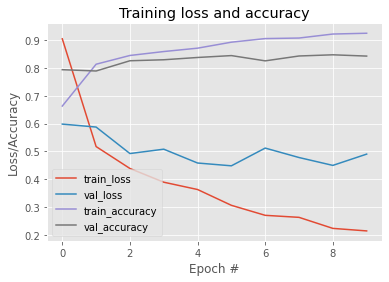

In [26]:
import matplotlib.pyplot as plt
N = np.arange(0, 10)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

**Visualization of the Model**

In [27]:
from graphviz import Digraph

dot = Digraph(comment='MLP')
dot.node('A', 'input1')
dot.node('B', 'h11')
dot.node('C', 'h12')
dot.node('D', 'h21')
dot.node('E', 'h22')
dot.node('F', 'h23')
dot.node('G', 'output1')
dot.edges(['AB', 'AC', 'BD', 'BE', 'BF', 'CD', 'CE', 'CF', 'DG', 'EG', 'FG'])
# check the generated source code
print(dot.source)

// MLP
digraph {
	A [label=input1]
	B [label=h11]
	C [label=h12]
	D [label=h21]
	E [label=h22]
	F [label=h23]
	G [label=output1]
	A -> B
	A -> C
	B -> D
	B -> E
	B -> F
	C -> D
	C -> E
	C -> F
	D -> G
	E -> G
	F -> G
}


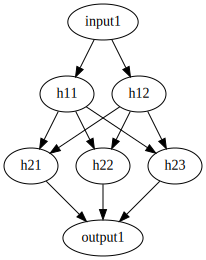

In [28]:
# view the graph
dot

In [29]:
# save the and render the source code
dot.render('simple_nn', format='png')

'simple_nn.png'

**Plotting the Model in Keras**
 
 1. Using Summary() Function

In [30]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(2, input_dim=1, activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 4         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


2. Using plot_model() Function

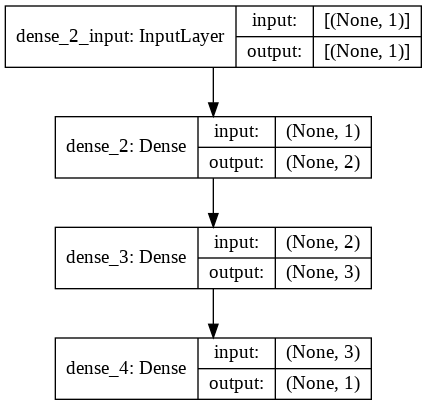

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='self_model_model_image_aug.png', show_shapes=True)